# 数据的处理(其实到目前为止还没有扩充)
前面的程序只能说是跑通，由于维度不匹配的问题，网络现在还无法正常训练，下面对输入输出数据进行处理，使其能够正常训练优化

如果按照我自己的想法，肯定是先对图像进行处理，处理结束后再基于新数据构建新的数据集，输入到网络进行训练，但是这么做有两个问题：
- 1.每次想添加新的处理方法的话就必须重新设计程序，这样程序和新生成的数据都会有很多，次数多了就会变得很乱。
- 2.对输入进行处理之后，必须也得对理想的标注信息进行同样的处理，这样才能保证训练正确，以裁剪处理为例，原始图像裁剪之后可以方便地获得新的图像，但是前面看到过，抓取框的标注信息都是以坐标形式保存的，当图像的四周被裁去之后，这个坐标肯定就是变了的，应用坐标变换的方式可能能够解决，但加上旋转，镜像等操作之后呢，无疑需要复杂的设计和运算才能保证最终的正确对应。

所以虚心学习，按照gg-cnn中的方法来解决这个问题，他这边的流程就很妙了，其实也不能说妙，感觉可能大家都是用这个方法吧，只是我第一次接触而已。

前面的程序中我们已经写好了，网络所标注的理想输出是由一张张的映射图来代表的，也就是说，最终这些损失的计算都不是根据各个参数啊，坐标这些来算的，而是直接针对两个图来进行，理想输出在这里面也是图，所以，我们只要把理想的原始输出图构建好了，数据增强处理之前它肯定是和原始的输入图是有对应关系的，像下图这样：
![对应的图](images/input_demo.png)

可以看到这些图都是相同尺寸的，输入与标注的对应关系也都在，所以，这个时候对它们应用相同的变换之后，结果肯定也是相互对应的。

下面开始实操

## 处理1.裁剪

### 输入的裁剪
不是方形的图片在后面的处理中总有可能出各种幺蛾子，但直接resize成方形的话又不能保证长宽比，所以考虑通过裁剪的方式，把图片的中心部分裁出来（可以看到边上全是背景，所以这么做是没有问题的）。

这项工作的执行需要两个参数：
- 1.中心点坐标
- 2.要裁出来的图像大小

图像大小自己指定长宽即可，中心点的坐标的确定有两个选择：
- 1.直接选图像的中心
- 2.多个抓取框的中心

这里保持跟GGCNN的一样，选择多个抓取框的中心，这么做的好处是可以保证对象位于最终裁出来的图片的中心，下面开始实操，先单个图片从测试，然后再将功能集成到抓取框类和图片类里面去。
- 抓取框类里面需要新添加一个计算多抓取框中心点坐标的函数
- 各个图像类需要添加一个裁剪函数，能够根据提供的中心点坐标和图像大小对原始图片进行裁剪

In [1]:
#先把文件都读进来
import os
import glob

cornell_path = 'cornell'
graspf = glob.glob(os.path.join(cornell_path,'*','pcd*cpos.txt'))
graspf.sort()

rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]

In [2]:
from net_data_stream.image import Image
from net_data_stream.grasp import Grasps

In [3]:
rgb_img = Image.from_file(rgbf[520])
grasps = Grasps.load_from_cornell_files(graspf[520])

In [4]:
#测试一下，没啥问题
print(rgb_img.img.shape)
for gr in grasps.grs:
    print(gr.center)

(480, 640, 3)
[321 289]
[317 293]
[320 297]
[321 280]
[316 305]
[290 298]
[291 276]


中心点的计算是比较简单的，就把各个抓取框的中心点拿出来，x,y各求个平均就完了

In [5]:
import numpy as np
centers = []
for gr in grasps.grs:
    centers.append(gr.center)
center = np.mean(np.array(centers),axis = 0).astype(np.uint)
print(center)

[310 291]


这就求出来了

裁剪先不做，先指定一个宽度的矩形结合这个中心点可视化一下看效果

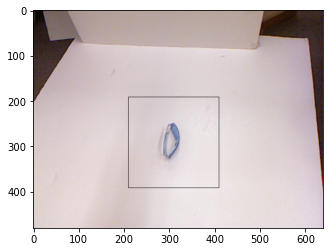

In [6]:
import cv2
import matplotlib.pyplot as plt
output_size = (200,200)

#注意原点在左上角
top_left = (center[0]-output_size[0]//2,center[1]-output_size[1]//2)
bottom_right = (center[0]+output_size[0]//2,center[1]+output_size[1]//2)
#这块这么确定角点比较直观，但是有些问题的，没有考虑边界的问题，如果给定的大小超过了边界范围，减出了负数就会出问题，后面采用了ggcnn里面定义的方法，加上了取值的限定，
#不过我感觉也不是很完善， 因为假设按照300*300去裁剪，出来一个负数的值，然后我把这个负数折算成0了，这样裁出来的图肯定就不是300*300了，后面计算损失肯定还是会报错，所以
#这里就注意不要给太大的值应该就没事了，比如最大400。
#好吧我错了，这里验证一下确实比较好，至于裁出来的图像形状不对，没关系，他最后加了一个resize()
corp_demo = cv2.rectangle(rgb_img.img,top_left,bottom_right,(0,0,1))
plt.imshow(rgb_img.img)
plt.show()

In [31]:
#因为原点就在左上方，所以最好还是这么来
top_left

(210, 191)

In [8]:
bottom_right

(410, 391)

裁剪的话也很简单，图片就是numpy数组，直接按照坐标对它切片就行

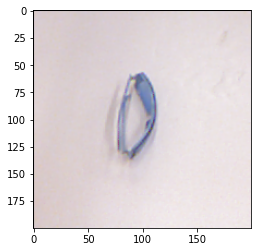

In [9]:
#按照我前面的设定，就应该是这么裁，计算方式可能跟ggcnn中的不太一样
croped_img = rgb_img.img[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
plt.imshow(croped_img)
plt.show()

下面把这两个功能集成到现有的类里面去

首先是计算中心点坐标，这个要加到grasps类里面去

In [10]:
from net_data_stream.grasp import str2num
from net_data_stream.grasp import Grasp

class Grasps:
    '''定义一个多抓取框处理类，主要功能是从原始的标注文件中读出多个抓取框并将其构建成多个单一的抓取框Grasp类，同时能够对这些属于同一对象的多个抓取框对象进行一些数据的统一集成处理'''
    def __init__(self,grs = None):
        '''
        :功能     : 多抓取框类初始化函数，功能是将属于一个对象的多个单独的抓取框集成到一个类里面来。
        :参数 grs : list,包含一个对象中多个抓取框类的列表
        '''
        if grs:
            self.grs = grs
        else:
            self.grs = []
    
    @classmethod
    def load_from_cornell_files(cls,cornell_grasp_files):
        '''
        :功能     : 从一个graspf文件中读取载入多个抓取框并构建成为这个类（其实就是从之前的那个get_rectangles改的）
        :参数 grs : list,包含一个对象中多个抓取框类的列表
        '''
        grasp_rectangles = []
        with open(cornell_grasp_files,'r') as f:
            while True:
                grasp_rectangle = []
                point0 = f.readline().strip()
                if not point0:
                    break
                point1,point2,point3 = f.readline().strip(),f.readline().strip(),f.readline().strip()
                if point0[0] == 'N':#后面发现有些坐标点坐标是NaN，会报错，这里处理一下，暂时还不晓得gg-cnn里面怎么处理的
                    break
                grasp_rectangle = np.array([str2num(point0),
                               str2num(point1),
                               str2num(point2),
                               str2num(point3)])
                grasp_rectangles.append(Grasp(grasp_rectangle))#找出各个框后就直接用它构造Grasp对象了

            return cls(grasp_rectangles)#返回实例化的类
        
    def generate_img(self,pos = True,angle = True,width = True,shape = (480,640)):
        '''
        :功能       :将本对象的多个的抓取框信息融合并生成指定的映射图，以这种方式返回定义一个抓取的多个参数，包括中心点，角度，宽度
        :参数 pos   :bool,是否生成返回位置映射图
        :参数 angle :bool,是否生成返回角度映射图
        :参数 width :bool,是否生成返回夹爪宽度映射图
        :参数 shape :tuple
        :返回       :融合本对象的多个抓取框信息的映射图
        '''
        
        if pos:
            pos_out = np.zeros(shape)
        else:
            pos_out = None
        if angle:
            angle_out = np.zeros(shape)
        else:
            angle_out = None
        if width:
            width_out = np.zeros(shape)
        else:
            width_out = None
        
        for gr in self.grs:
            rr,cc = gr.compact_polygon_coords(shape)#shape的指定还是很重要的，可以考虑图像边界
            
            if pos:
                pos_out[cc,rr] = 1.0
            if angle:
                angle_out[cc,rr] = gr.angle
            if width:
                width_out[cc,rr] = gr.width

        return pos_out,angle_out,width_out
    
    @property
    def center(self):
        '''
        :功能       :计算本类中所包含的多个抓取框共同的中心
        :返回       :ndarray，中心坐标
        '''
        centers = []
        for gr in self.grs:
            centers.append(gr.center)
        center = np.mean(np.array(centers),axis = 0).astype(np.uint)
        return center

In [11]:
grasps = Grasps.load_from_cornell_files(graspf[520])

In [12]:
grasps.center

array([310, 291], dtype=uint32)

正常输出了，ojbk，这块更新后的程序放在了grasp_pro.py里面了

下面为图像类添加裁剪函数

In [13]:
#import cv2 #这块本来是用cv2.imread来做读取的，后面发现读不了tiff，所以就改用imageio了
from imageio import imread
import numpy as np

class Image:
    '''定义一个图像类，主要功能是将原始的图像输入转化为适合网络训练的格式并根据图像处理需求完成一些其他功能'''
    def __init__(self,img):
        '''
        :功能 :类初始化函数
        :参数 :ndarray,原始图像
        '''
        self.img = img
    
    @classmethod
    def from_file(cls,file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(imread(file_path))
    
    def img_format(self):
        '''
        :功能 :将原始图像转换为指定格式
        '''
        pass
    
    def normalize(self):
        '''
        :功能 :将图像像素值标准化至[0,1]范围
        '''
        self.img = self.img.astype('float32')/255.0
        self.img = self.img-self.img.mean()
        
    def crop(self,top_left, bottom_right):
        '''
        :功能              :按照给定参数对图像进行裁剪操作
        :参数 top_left     :ndarray,要裁剪区域的左上角点坐标
        :参数 bottom_right :ndarray,要裁剪区域的右下角点坐标
        '''
        self.img = self.img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

class DepthImage(Image):
    '''深度图像类，读取，载入，正则等预处理都是一样的，后面可能会添加一些针对深度图的专属处理功能'''
    def __init__(self,img):
        super(DepthImage,self).__init__(img)  
    

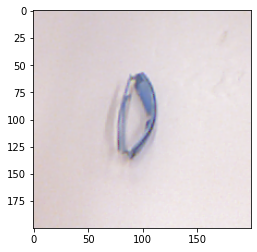

In [14]:
rgb_img = Image.from_file(rgbf[520])
rgb_img.crop(top_left,bottom_right)
plt.imshow(rgb_img.img)
plt.show()

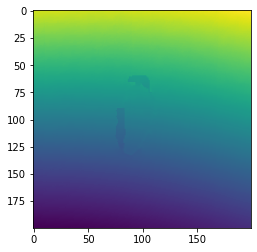

In [15]:
depth_img = DepthImage.from_file(depthf[520])
depth_img.crop(top_left,bottom_right)
depth_img.normalize()
plt.imshow(depth_img.img)
plt.show()

工作正常，下面考虑在哪个地方把参数传递一下，也就是在哪将中心坐标读出来，然后结合要输出的图的长宽，生成top_left,bottom_right这两个参数。

考虑一下，还是直接仿照ggcnn的放法，在cornell数据集类里面添加一个获取参数函数_get_crop_attrs()，这时候也得注意给cornell数据集添加一个output_size参数了。

In [16]:
import torch

class Cornell(torch.utils.data.Dataset):
    #载入cornell数据集的类
    def __init__(self,file_dir,include_depth=True,include_rgb=True,start = 0.0,end = 1.0,output_size = 300):
        '''
        :功能               : 数据集封装类的初始化函数，功能包括数据集读取，数据集划分，其他参数初始化等
        :参数 file_dir      : str,按照官方文档的示例和之前的经验，这里需要读入数据集，所以需要指定数据的存放路径
        :参数 include_depth : bool,是否包含depth图像输入
        :参数 include_rgb   : bool,是否包含rgb图像输入
        :参数 output_size   : 各图片的输出大小，裁剪得到
        :参数 start,end     : float,为了方便数据集的拆分，这里定义添加两个边界参数start,end
        :返回 None
        ''' 
        super(Cornell,self).__init__()
        
        #一些参数的传递
        self.include_depth = include_depth
        self.include_rgb = include_rgb
        self.output_size = output_size
        #去指定路径载入数据集数据
        graspf = glob.glob(os.path.join(file_dir,'*','pcd*cpos.txt'))
        graspf.sort()
        
        
        l = len(graspf)
        if l == 0:
            raise FileNotFoundError('没有查找到数据集，请检查路径{}'.format(file_dir))
        
        rgbf = [filename.replace('cpos.txt','r.png') for filename in graspf]
        depthf = [filename.replace('cpos.txt','d.tiff') for filename in graspf]
        
        #按照设定的边界参数对数据进行划分并指定为类的属性
        self.graspf = graspf[int(l*start):int(l*end)]
        self.rgbf = rgbf[int(l*start):int(l*end)]
        self.depthf = depthf[int(l*start):int(l*end)]
    @staticmethod
    def numpy_to_torch(s):
        '''
        :功能     :将输入的numpy数组转化为torch张量，并指定数据类型，如果数据没有channel维度，就给它加上这个维度
        :参数 s   :numpy ndarray,要转换的数组
        :返回     :tensor,转换后的torch张量
        '''
        if len(s.shape) == 2:
            return torch.from_numpy(np.expand_dims(s, 0).astype(np.float32))
        else:
            return torch.from_numpy(s.astype(np.float32))
    
    def _get_crop_attrs(self,idx):
        '''
        :功能     :读取多抓取框中心点的坐标，并结合output_size计算要裁剪的左上角点坐标
        :参数 idx :int,
        :返回     :计算出来的多抓取框中心点坐标和裁剪区域左上角点坐标
        '''
        grasp_rectangles = Grasps.load_from_cornell_files(graspf[idx])
        center = grasp_rectangles.center
        #按照ggcnn里面的话，这里本该加个限制条件，防止角点坐标溢出边界，但前面分析过，加不加区别不大，就不加了
        left = center[0]-self.output_size//2
        top = center[1]-self.output_size//2
        
        return center,left,top
    
    def get_rgb(self,idx):
        '''
        :功能     :读取返回指定id的rgb图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的rgb图像
        '''
        rgb_img = Image.from_file(self.rgbf[idx])
        rgb_img.normalize()
        center,left,top = self._get_crop_attrs(idx)
        rgb_img.crop((left,top),(left+self.output_size,top+self.output_size))
        return rgb_img.img
    
    #因为有时候只输入RGB三通道信息，所以，定义两个返回函数，一个读取RGB一个读取深度
    def get_depth(self,idx):
        '''
        :功能     :读取返回指定id的depth图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的depth图像
        '''
        #目前这个DepthImage类还没有定义，后面仿照Image类给它定义一下
        depth_img = DepthImage.from_file(self.depthf[idx])
        depth_img.normalize()
        center,left,top = self._get_crop_attrs(idx)
        depth_img.crop((left,top),(left+self.output_size,top+self.output_size))
        
        return depth_img.img
    
    def get_grasp(self,idx):
        '''
        :功能       :读取返回指定id的抓取标注参数并将多个抓取框的参数返回融合
        :参数 idx   :int,要读取的数据id
        :参数 pos   :bool,是否生成返回位置映射图
        :参数 angle :bool,是否生成返回角度映射图
        :参数 width :bool,是否生成返回夹爪宽度映射图
        :返回       :以图片的方式返回定义一个抓取的多个参数，包括中心点，角度，宽度和长度
        '''
        grasp_rectangles = Grasps.load_from_cornell_files(self.graspf[idx])
        pos_img,angle_img,width_img = grasp_rectangles.generate_img(shape = (480,640))
        
        return pos_img,angle_img,width_img
    def __getitem__(self,idx):
        # 载入深度图像
        if self.include_depth:
            depth_img = self.get_depth(idx)
            x = self.numpy_to_torch(depth_img)
        # 载入rgb图像
        if self.include_rgb:
            rgb_img = self.get_rgb(idx)
            #torch是要求channel-first的，检测一下，如果读进来的图片是channel-last就调整一下，ggcnn中目前我没看到在哪调整的，但肯定是做了的
            if rgb_img.shape[2] == 3:
                rgb_img = np.moveaxis(rgb_img,2,0)
            x = self.numpy_to_torch(rgb_img)
        if self.include_depth and self.include_rgb:#如果灰度信息和rgb信息都要的话，就把他们堆到一起构成一个四通道的输入，
            x = self.numpy_to_torch(
                np.concatenate(
                    (np.expand_dims(depth_img,0),rgb_img),0
                )
            )
            
        # 载入抓取标注参数
        pos_img,angle_img,width_img = self.get_grasp(idx)
        # 处理一下角度信息，因为这个角度值区间比较大，不怎么好处理，所以用两个三角函数把它映射一下：
        cos_img = self.numpy_to_torch(np.cos(2*angle_img))
        sin_img = self.numpy_to_torch(np.sin(2*angle_img))
        
        pos_img = self.numpy_to_torch(pos_img)
        
        # 限定抓取宽度范围并将其映射到[0,1]
        width_img = np.clip(width_img, 0.0, 150.0)/150.0
        width_img = self.numpy_to_torch(width_img)
        
        return x,(pos_img,cos_img,sin_img,width_img)
    
    #映射类型的数据集，别忘了定义这个函数
    def __len__(self):
        return len(self.graspf)

改完了，在数据集层面测试一下：

In [17]:
#建立数据集对象
cornell_data = Cornell('cornell')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 1)

#从数据集中读取一个样本
for x,y in dataset:
    xc = x
    yc = y
    break

In [18]:
xc.shape

torch.Size([1, 4, 300, 300])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


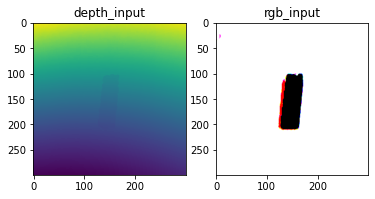

In [19]:
depth_img = xc[0][0].data.numpy()
rgb_img = xc[0][1:4].data.numpy()

rgb_img = np.moveaxis(rgb_img,0,2)*255
plt.subplot(121)
plt.title('depth_input')
plt.imshow(depth_img)
plt.subplot(122)
plt.title('rgb_input')
plt.imshow(rgb_img)
plt.show()

输出正常，一切ok

后面还需要对输出映射图的尺寸进行修改，吃完饭回来再说吧

回来了，输出映射如果不改的话，可以查看一下，目前我们给网络的输入的标注信息是这样的：

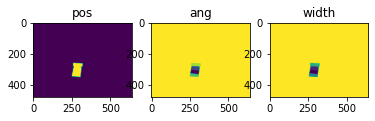

In [20]:
pos = yc[0][0][0].data.numpy()
ang = yc[1][0][0].data.numpy()
wid = yc[2][0][0].data.numpy()

plt.subplot(131)
plt.title('pos')
plt.imshow(pos)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang)
plt.subplot(133)
plt.title('width')
plt.imshow(wid)
plt.show()

可以看到，这就是数据集原始图片所对应的抓取框，跟我们裁剪过的图片已经不对应了，这样训练是不可能有结果的，所以需要将这些映射也裁剪成跟上面一样的尺寸，使其保持坐标的对应。

### 输出的裁剪

- 方法一：首先这块也可以通过直接裁剪的方式实现，比如下面实验一下：

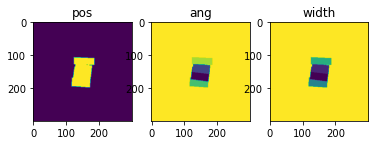

In [21]:
#首先手动获取一下裁剪的角点坐标
grasps = Grasps.load_from_cornell_files(graspf[0])

output_size = 300

left = grasps.center[0]-output_size//2
top = grasps.center[1]-output_size//2

pos_croped = pos[top:top+output_size,left:left+output_size]
ang_croped = ang[top:top+output_size,left:left+output_size]
wid_croped = wid[top:top+output_size,left:left+output_size]

plt.subplot(131)
plt.title('pos')
plt.imshow(pos_croped)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang_croped)
plt.subplot(133)
plt.title('width')
plt.imshow(wid_croped)
plt.show()

可以看到，成功将抓取框也移动到了**指定大小**生成图片的中央，这种方法的话只需要将生成的那三张图片转换成前面定义的Image对象，然后直接像前两张一样，直接应用类内的crop函数即可，比较简单，但ggcnn中用的是另外一种平移的方法

- 方法二：平移的方法

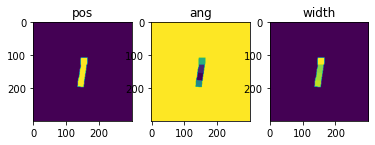

In [22]:
#注意一定要将这一块放在最后，因为这个是为了测试ggcnn原始函数而设置的，导入这个类之后会影响前面的定义
#一开始我没怎么搞懂ggcnn里面是怎么工作的，所以就索性用它默认设计的类来测试一下

from data_augmentation.grasp_ggcnn import GraspRectangles
from data_augmentation.grasp_ggcnn import GraspRectangle
from data_augmentation.grasp_ggcnn import Grasp

output_size = 300

grs = GraspRectangles.load_from_cornell_file(graspf[0])

#它就是通过这一行来修正抓取框坐标的，相当于把抓取框的坐标整体向左上方平移了一下，使其位于我生成图像的中心
grs.offset((-(grs.center[0]-output_size//2),-((grs.center[1]-output_size//2))))
pos,ang,width = grs.draw((300,300))

plt.subplot(131)
plt.title('pos')
plt.imshow(pos)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang)
plt.subplot(133)
plt.title('width')
plt.imshow(width)
plt.show()

这两种方法的原理参考images/corp.pdf，我绘制的原理图

另外这块还有一点需要注意，就是ggcnn里面将抓取框矩形矩形变窄了三倍，这也是我之前想到的一个问题，是很合理的，总能不能说你标的边缘处也能应用那些抓取参数吧，具体操作是在构建Grasp对象的时候把length参数除了3，我方法一生成的没有除（上上图），方法二的除了，所以要窄了许多（上图）：

该有的东西前面都说过了，该改的部分也都改了，下面测试一下是否正常工作，然后把它整理到一个py程序里面去.

In [23]:
from data_augmentation.grasp_pro import Grasp
from data_augmentation.grasp_pro import Grasps
from data_augmentation.grasp_pro import Grasp_cpaw

In [24]:
grs = Grasps.load_from_cornell_files(graspf[0])
test = Grasp_cpaw(grs.grs[0].center, grs.grs[0].angle, grs.grs[0].length, grs.grs[0].width).as_gr

In [25]:
#把这些参数打印出来看框还是不是原先的框
print(grs.grs[0].points)
print(test.points)

[[253 320]
 [309 324]
 [307 350]
 [251 346]]
[[252.92894788 319.99472969]
 [308.92894788 323.99472969]
 [307.07105212 350.00527031]
 [251.07105212 346.00527031]]


In [26]:
print(grs.grs[0].center)
print(test.center)

[280 335]
[280 335]


In [27]:
print(grs.grs[0].angle)
print(test.angle)

-0.07130746478529026
-0.07130746478529026


In [28]:
print(grs.grs[0].width)
print(test.width)

56.142675390472796
56.14267539047277


In [29]:
print(grs.grs[0].length)
print(test.length)

26.076809620810597
26.0768096208106


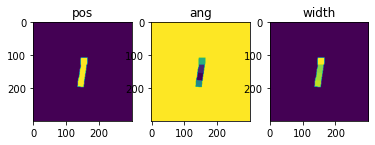

In [30]:
output_size = 300

grs = Grasps.load_from_cornell_files(graspf[0])

#它就是通过这一行来修正抓取框坐标的，相当于把抓取框的坐标整体向左上方平移了一下，使其位于我生成图像的中心
grs.offset((-(grs.center[0]-output_size//2),-((grs.center[1]-output_size//2))))
pos,ang,width = grs.generate_img((300,300))

plt.subplot(131)
plt.title('pos')
plt.imshow(pos)
plt.subplot(132)
plt.title('ang')
plt.imshow(ang)
plt.subplot(133)
plt.title('width')
plt.imshow(width)
plt.show()

测试无误，ojbk，可以看到和直接用grasp_ggcnn是一样的（但有个问题哈，本来我没除以三的时候，对应的颜色和除以三不一样，还以为我错了，后面除了三发现是一样的，不应该啊，，，）

好吧我傻逼了，这颜色反映的是宽度大小，你宽度缩小了三倍肯定这颜色肯定要变了啊。

不过中间调的时候还是有些问题的，因为我定义的一些不对应关系，在as_gr里面还是需要好好改一下的，详见对应的grasp_pro.py文件

最后，在调用offset函数的时候，它用到了一个魔法方法\_\_getattr\_\_，记在support__files里面了

最终网络的输入输出见下面两图(编号30)，效果由data_augmentation_main.py实现

![aug_input](images/aug_input.png)
![aug_output](images/aug_output.png)